# Project 1A: NASA-HTTP Log analysis 

Last update: Jan 20, 2019

In [2]:
# Name: <Please put your name here>

%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Getting the data

First, go to [http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html](http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) and download two files:

1. [ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz](ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz)
2. [ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz](ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz)

Save and unzip them into the `data` directory. Your data directory should contain the following files:

    data/NASA_access_log_Jul95
    data/NASA_access_log_Aug95
    data/GeoIP.dat

<div class="alert alert-block alert-warning">
    <b>Tip:</b> You can run shell commands such as <code>wget</code> and <code>gunzip</code> 
        from within the notebook using shell escape (!).
</div>

In [11]:
## Run wget and gunzip from here
!wget http://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz -P data/
!wget http://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz -P data/

--2019-02-01 06:29:20--  http://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz
Resolving ita.ee.lbl.gov (ita.ee.lbl.gov)... 131.243.2.164
Connecting to ita.ee.lbl.gov (ita.ee.lbl.gov)|131.243.2.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20676672 (20M) [application/x-gzip]
Saving to: `data/NASA_access_log_Jul95.gz'

NASA_access_log_Jul 100%[===================>]  19.72M  1.56MB/s    in 14s     

2019-02-01 06:29:34 (1.41 MB/s) - `data/NASA_access_log_Jul95.gz' saved [20676672/20676672]

--2019-02-01 06:29:34--  http://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz
Resolving ita.ee.lbl.gov (ita.ee.lbl.gov)... 131.243.2.164
Connecting to ita.ee.lbl.gov (ita.ee.lbl.gov)|131.243.2.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16633316 (16M) [application/x-gzip]
Saving to: `data/NASA_access_log_Aug95.gz'

NASA_access_log_Aug 100%[===================>]  15.86M   249KB/s    in 60s     

2019-02-01 06:30:36 (269 KB/s) - `data/NASA

In [12]:
!gunzip data/NASA_access_log_Jul95.gz
!gunzip data/NASA_access_log_Aug95.gz

In [13]:
! ls -l data/

total 730712
-rw-r--r--  1 JarHan  staff    1062137 Jan 21 03:57 GeoIP.dat
-rw-r--r--  1 JarHan  staff  167813770 Apr 26  1996 NASA_access_log_Aug95
-rw-r--r--  1 JarHan  staff  205242368 Apr 26  1996 NASA_access_log_Jul95


### Pre-processing 

Now you will write code to pre-process the log data and store it in an intermediate format that is easier to work with. We recommend that you store the data as a **list of python dictionaries**. Here are the first few lines of the log file.

```
199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245
unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985
199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085
burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0
```

The above entries should be parsed and converted to:
    
    [
        {
          'ip': '199.72.81.55',
          'time': '01/Jul/1995:00:00:01 -0400',
          'request': 'GET /history/apollo/ HTTP/1.0',
          'status': '200',
          'size': '6245'
        },
        {
          'ip': 'unicomp6.unicomp.net',
          'time': '01/Jul/1995:00:00:06 -0400',
          'request': 'GET /shuttle/countdown/ HTTP/1.0',
          'status': '200',
          'size': '3985'
        },
        ...
    ]

<div class="alert alert-block alert-warning">
    <b>Remark:</b> There are some log entries that are malformed. You may ignore them. 
</div>

In [3]:
def generateDicts(log_fh):
    currentDict = {}
    try:
        for line in log_fh:
            try:
                if currentDict:
                    yield currentDict
                currentDict = {"ip": line.split(' - - ')[0],
                               "time": line.split('[')[1].split(']')[0],
                               "request": line.split('"')[1],
                               "status": line.split(' ')[-2],
                               "size": line.split(' ')[-1].split("\n")[0]}
            except:
                pass            
        yield currentDict
    except Exception as e:
        print(str(e))
        pass

def parse_log(filename):
    with open(filename, encoding="utf8", errors='ignore') as f:
        return list(generateDicts(f))

In [4]:
# Now parse the two files
jul95 = parse_log('data/NASA_access_log_Jul95')
aug95 = parse_log('data/NASA_access_log_Aug95')

In [5]:
# Expected output
import pprint
pprint.pprint(jul95[:2])
pprint.pprint(aug95[:2])

[{'ip': '199.72.81.55',
  'request': 'GET /history/apollo/ HTTP/1.0',
  'size': '6245',
  'status': '200',
  'time': '01/Jul/1995:00:00:01 -0400'},
 {'ip': 'unicomp6.unicomp.net',
  'request': 'GET /shuttle/countdown/ HTTP/1.0',
  'size': '3985',
  'status': '200',
  'time': '01/Jul/1995:00:00:06 -0400'}]
[{'ip': 'in24.inetnebr.com',
  'request': 'GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0',
  'size': '1839',
  'status': '200',
  'time': '01/Aug/1995:00:00:01 -0400'},
 {'ip': 'uplherc.upl.com',
  'request': 'GET / HTTP/1.0',
  'size': '0',
  'status': '304',
  'time': '01/Aug/1995:00:00:07 -0400'}]


In [7]:
# Expected output
import pprint
pprint.pprint(jul95[:2])
pprint.pprint(aug95[:2])

[{'ip': '199.72.81.55',
  'request': 'GET /history/apollo/ HTTP/1.0',
  'size': '6245',
  'status': '200',
  'time': '01/Jul/1995:00:00:01 -0400'},
 {'ip': 'unicomp6.unicomp.net',
  'request': 'GET /shuttle/countdown/ HTTP/1.0',
  'size': '3985',
  'status': '200',
  'time': '01/Jul/1995:00:00:06 -0400'}]
[{'ip': 'in24.inetnebr.com',
  'request': 'GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0',
  'size': '1839',
  'status': '200',
  'time': '01/Aug/1995:00:00:01 -0400'},
 {'ip': 'uplherc.upl.com',
  'request': 'GET / HTTP/1.0',
  'size': '0',
  'status': '304',
  'time': '01/Aug/1995:00:00:07 -0400'}]


### Create the DataFrame

In this part, we will create a data frame from `jul95` and `aug95` and clean it up a little bit. 

<div class="alert alert-block alert-success">
    <b>Your Task:</b> First, create a data frame called <code>df</code> from <code>jul95</code> and <code>aug95</code>
</div>

In [19]:
# Fill code here
combined = jul95 + aug95
df = pd.DataFrame(combined)

<div class="alert alert-block alert-success">
    <b>Your Task:</b> Show the first two rows of <code>df</code>
</div>

In [20]:
# Fill code here
df.head(2)

,ip,request,size,status,time
0,199.72.81.55,GET /history/apollo/ HTTP/1.0,6245,200,01/Jul/1995:00:00:01 -0400
1,unicomp6.unicomp.net,GET /shuttle/countdown/ HTTP/1.0,3985,200,01/Jul/1995:00:00:06 -0400


In [13]:
# Expected output

,ip,request,size,status,time
0,199.72.81.55,GET /history/apollo/ HTTP/1.0,6245,200,01/Jul/1995:00:00:01 -0400
1,unicomp6.unicomp.net,GET /shuttle/countdown/ HTTP/1.0,3985,200,01/Jul/1995:00:00:06 -0400


<div class="alert alert-block alert-success">
    <b>Your Task:</b> Show the last two rows of <code>df</code>
</div>

In [21]:
# Fill code here
df.tail(2)

,ip,request,size,status,time
3461611,www-c8.proxy.aol.com,GET /icons/unknown.xbm HTTP/1.0,515,200,31/Aug/1995:23:59:52 -0400
3461612,cindy.yamato.ibm.co.jp,GET /images/kscmap-small.gif HTTP/1.0,39017,200,31/Aug/1995:23:59:53 -0400


In [12]:
# Expected output

,ip,request,size,status,time
3461611,www-c8.proxy.aol.com,GET /icons/unknown.xbm HTTP/1.0,515,200,31/Aug/1995:23:59:52 -0400
3461612,cindy.yamato.ibm.co.jp,GET /images/kscmap-small.gif HTTP/1.0,39017,200,31/Aug/1995:23:59:53 -0400


<div class="alert alert-block alert-success">
    <b>Your Task:</b> Convert <code>time</code> column to datetime format and make an index out of it. Use pd.to_datetime()
</div>

In [22]:
# Fill code here
df["time"] = pd.to_datetime(df["time"], format="%d/%b/%Y:%H:%M:%S -0400")
df = df.set_index("time")
df.head()

,ip,request,size,status
time,,,,
1995-07-01 00:00:01,199.72.81.55,GET /history/apollo/ HTTP/1.0,6245,200
1995-07-01 00:00:06,unicomp6.unicomp.net,GET /shuttle/countdown/ HTTP/1.0,3985,200
1995-07-01 00:00:09,199.120.110.21,GET /shuttle/missions/sts-73/mission-sts-73.ht...,4085,200
1995-07-01 00:00:11,burger.letters.com,GET /shuttle/countdown/liftoff.html HTTP/1.0,0,304
1995-07-01 00:00:11,199.120.110.21,GET /shuttle/missions/sts-73/sts-73-patch-smal...,4179,200


<div class="alert alert-block alert-success">
    <b>Your Task:</b> Drop <code>time</code> column and cast <code>status</code> column to type <code>int</code>. Use .astype()
</div>


In [23]:
# Fill code here
print(df.status.dtype)
df["status"] = df["status"].apply(lambda x : int(x))
print(df.status.dtype)
df.head()

object
int64


,ip,request,size,status
time,,,,
1995-07-01 00:00:01,199.72.81.55,GET /history/apollo/ HTTP/1.0,6245,200
1995-07-01 00:00:06,unicomp6.unicomp.net,GET /shuttle/countdown/ HTTP/1.0,3985,200
1995-07-01 00:00:09,199.120.110.21,GET /shuttle/missions/sts-73/mission-sts-73.ht...,4085,200
1995-07-01 00:00:11,burger.letters.com,GET /shuttle/countdown/liftoff.html HTTP/1.0,0,304
1995-07-01 00:00:11,199.120.110.21,GET /shuttle/missions/sts-73/sts-73-patch-smal...,4179,200


Some of the rows in the `size` column contain '-' string, so we can't convert them with *astype*. We can apply a custom function to this column, that will convert all dashes to NaN, and the rest to floats, additionally converting from bytes to megabytes:

In [24]:
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = float(x)/1048576.
    return x

<div class="alert alert-block alert-success">
    <b>Your Task:</b> Apply the above fuction to <code>size</code> column of df. Try using .apply()
</div>



In [25]:
# Fill code here
print(df.size.dtype)

df["size"] = df["size"].apply(dash2nan)
df.head()

int64


,ip,request,size,status
time,,,,
1995-07-01 00:00:01,199.72.81.55,GET /history/apollo/ HTTP/1.0,0.005956,200
1995-07-01 00:00:06,unicomp6.unicomp.net,GET /shuttle/countdown/ HTTP/1.0,0.003800,200
1995-07-01 00:00:09,199.120.110.21,GET /shuttle/missions/sts-73/mission-sts-73.ht...,0.003896,200
1995-07-01 00:00:11,burger.letters.com,GET /shuttle/countdown/liftoff.html HTTP/1.0,0.000000,304
1995-07-01 00:00:11,199.120.110.21,GET /shuttle/missions/sts-73/sts-73-patch-smal...,0.003985,200


Now our data frame is ready! At this point, your data frame should look like the following:

In [47]:
# Expected output

,ip,request,size,status
time,,,,
1995-07-01 00:00:01,199.72.81.55,GET /history/apollo/ HTTP/1.0,0.005956,200
1995-07-01 00:00:06,unicomp6.unicomp.net,GET /shuttle/countdown/ HTTP/1.0,0.003800,200
1995-07-01 00:00:09,199.120.110.21,GET /shuttle/missions/sts-73/mission-sts-73.ht...,0.003896,200
1995-07-01 00:00:11,burger.letters.com,GET /shuttle/countdown/liftoff.html HTTP/1.0,0.000000,304
1995-07-01 00:00:11,199.120.110.21,GET /shuttle/missions/sts-73/sts-73-patch-smal...,0.003985,200


### HTTP Traffic analysis

<div class="alert alert-block alert-success">
    <b>Your Task:</b> Plot the response size over time from 9am to 10am on Jul 13, 1995
</div>

In [26]:
# Fill code here
start_date = "1995-07-13 09:00:00"
end_date = "1995-07-13 10:00:00"
df_jul13 = df[(df.index >= start_date) & (df.index <= end_date)]
df_jul13.head()

,ip,request,size,status
time,,,,
1995-07-13 09:00:00,163.205.16.100,GET /images/USA-logosmall.gif HTTP/1.0,0.000223,200
1995-07-13 09:00:00,bocagate.bocaraton.ibm.com,GET /shuttle/countdown/video/livevideo.jpeg HT...,0.044905,200
1995-07-13 09:00:00,vagrant.vf.mmc.com,GET /htbin/cdt_clock.pl HTTP/1.0,0.000717,200
1995-07-13 09:00:00,163.205.16.100,GET /images/WORLD-logosmall.gif HTTP/1.0,0.000638,200
1995-07-13 09:00:00,ppco.com,GET /shuttle/countdown/images/cdtclock.gif HTT...,0.033081,200


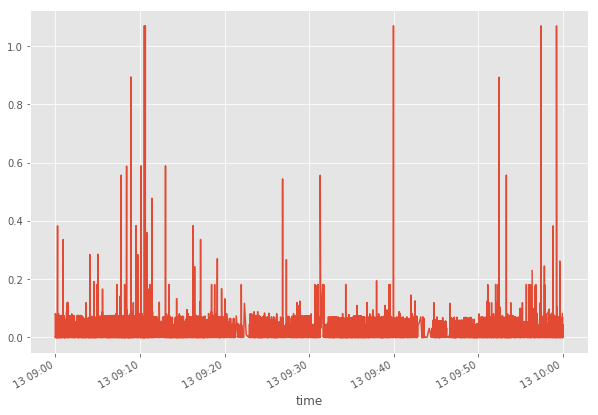

In [27]:
# plot with pandas own matplotlib wrapper
plt.figure(figsize=(10,7))
df_jul13["size"].plot()

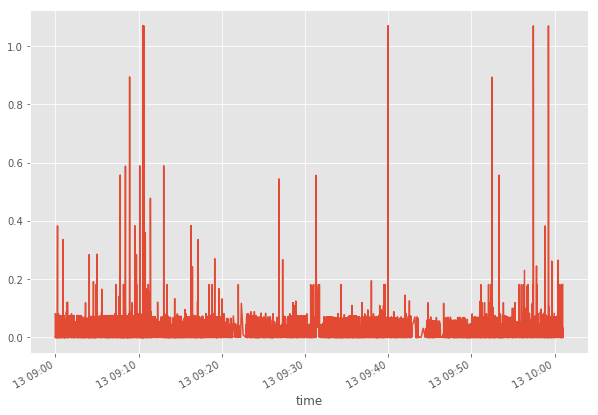

In [20]:
# Expected output

<div class="alert alert-block alert-success">
    <b>Your Task:</b> Use `.resample()` along with `.sum()` to resample the data and plot the traffic over time for all days. Use '10T' (every 10 minutes) as the sampling rate
</div>

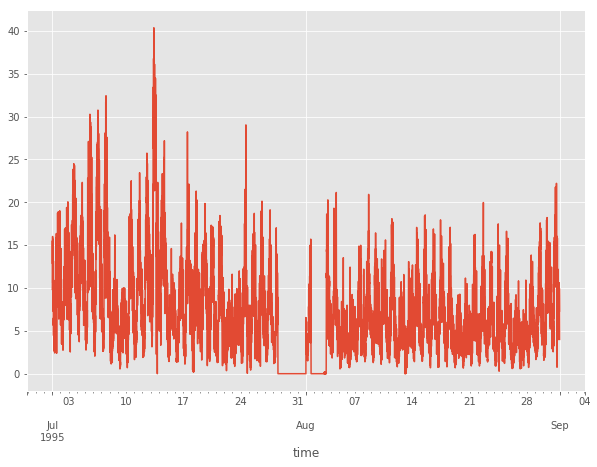

In [188]:
# Fill code here
df_re = df.resample('10T').sum()
plt.figure(figsize=(10,7))
df_re["size"].plot()

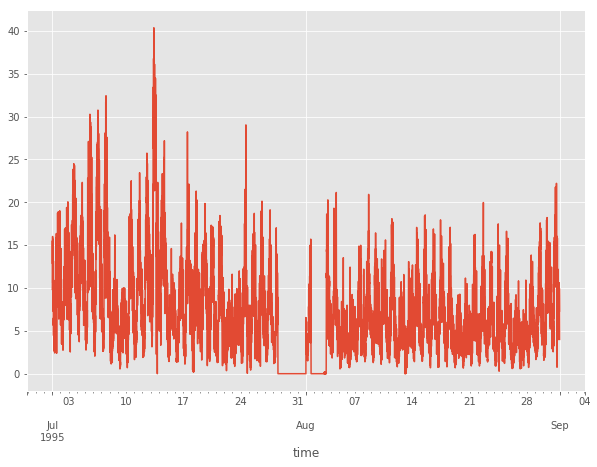

In [21]:
# Expected output

<div class="alert alert-block alert-success">
    <b>Your Task:</b> Now try to zoom into 13 Jul 1995.
</div>

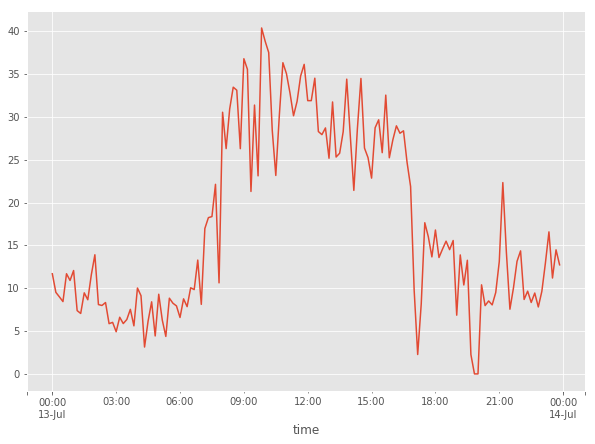

In [198]:
# Fill code here

start_date = "1995-07-13 00:00:00"
end_date = "1995-07-14 00:00:00"
df_allJul13 = df[(df.index >= start_date) & (df.index < end_date)]

df_allJul13_re = df_allJul13.resample('10T').sum()
plt.figure(figsize=(10,7))
df_allJul13_re["size"].plot()

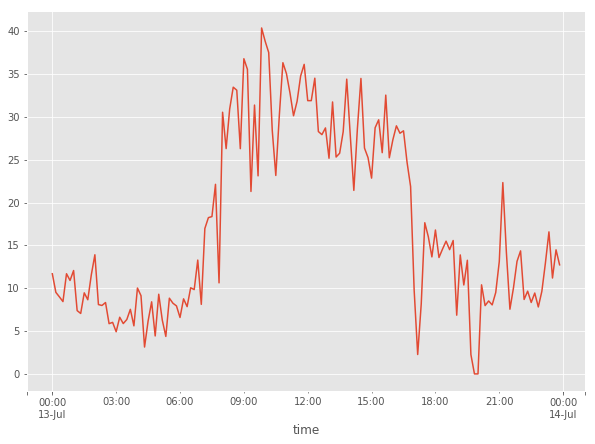

In [22]:
# Expected output

<div class="alert alert-block alert-success">
    <b>Your Task:</b> Show requests that has response biggger than 3MB.
</div>

In [199]:
# Fill code here
df_bigger_3mb = df[(df["size"] > 3)]
df_bigger_3mb

,ip,request,size,status
time,,,,
1995-07-07 10:28:56,spider.tbe.com,GET /statistics/1995/bkup/Mar95_full.html HTTP...,3.009318,200
1995-07-07 14:03:32,derec,GET /shuttle/countdown/video/livevideo.jpeg HT...,6.507812,200
1995-07-09 09:22:14,netspace.net.au,GET /statistics/1995/bkup/Mar95_full.html HTTP...,3.009318,200
1995-07-13 14:38:43,acf4.nyu.edu,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-07-14 09:11:29,163.206.89.4,GET /statistics/1995/bkup/Mar95_full.html HTTP...,3.009318,200
1995-07-17 13:31:01,jcj8363.dukepower.com,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-07-22 13:08:18,wuzza.harvard.edu,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-07-25 17:58:56,198.122.135.40,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-08-03 15:51:23,163.205.156.16,GET /statistics/1995/Jul/Jul95_reverse_domains...,3.263424,200


In [23]:
# Expected output

,ip,request,size,status
time,,,,
1995-07-07 10:28:56,spider.tbe.com,GET /statistics/1995/bkup/Mar95_full.html HTTP...,3.009318,200
1995-07-07 14:03:32,derec,GET /shuttle/countdown/video/livevideo.jpeg HT...,6.507812,200
1995-07-09 09:22:14,netspace.net.au,GET /statistics/1995/bkup/Mar95_full.html HTTP...,3.009318,200
1995-07-13 14:38:43,acf4.nyu.edu,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-07-14 09:11:29,163.206.89.4,GET /statistics/1995/bkup/Mar95_full.html HTTP...,3.009318,200
1995-07-17 13:31:01,jcj8363.dukepower.com,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-07-22 13:08:18,wuzza.harvard.edu,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-07-25 17:58:56,198.122.135.40,GET /statistics/1995/bkup/Mar95_full.html HT...,3.009318,200
1995-08-03 15:51:23,163.205.156.16,GET /statistics/1995/Jul/Jul95_reverse_domains...,3.263424,200


<div class="alert alert-block alert-success">
   What is the typical size of the server's response? Make a histogram of response sizes smaller than 3MB. Set number of bins to 10.
</div>


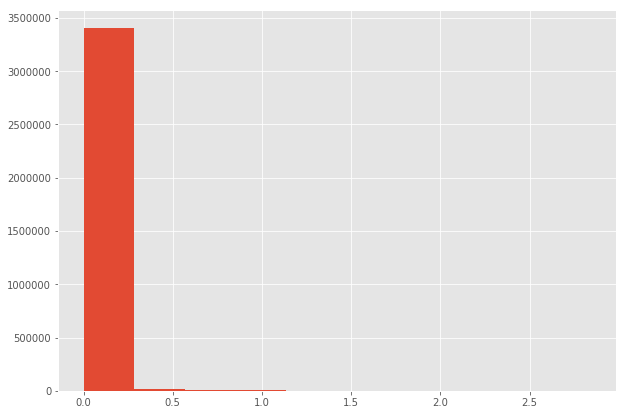

In [202]:
# Fill code here
df_smaller_3mb = df[(df["size"] < 3)]
plt.figure(figsize=(10,7))
df_smaller_3mb["size"].hist(bins=10)

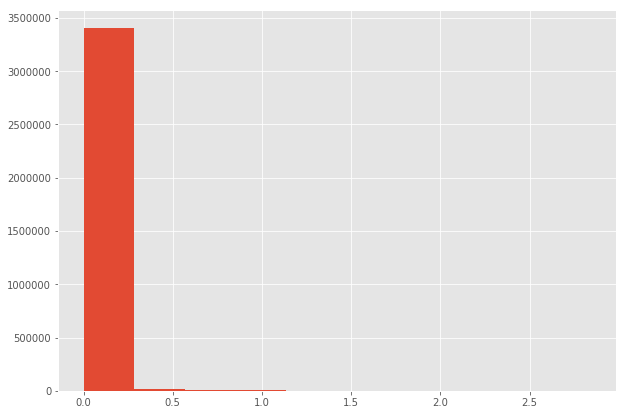

In [24]:
# Expected output

<div class="alert alert-block alert-success">
So most of the files are less than 0.5 MB large. In fact they are even smaller. Show a histogram of responses sizes smaller than 0.05 MB. Set number of bins to 30.
</div>



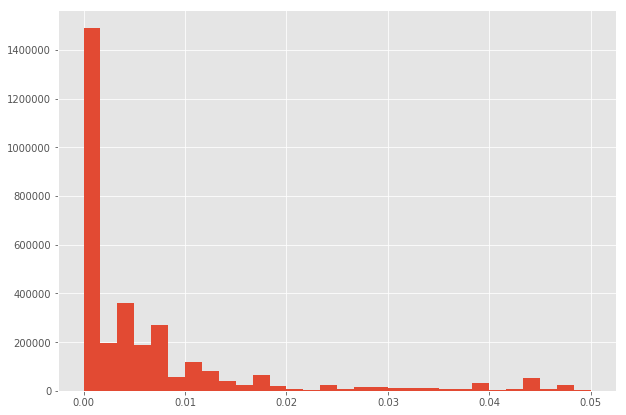

In [210]:
# Fill code here
df_smaller_005mb = df[(df["size"] < 0.05)]
plt.figure(figsize=(10,7))
df_smaller_005mb["size"].hist(bins=30)

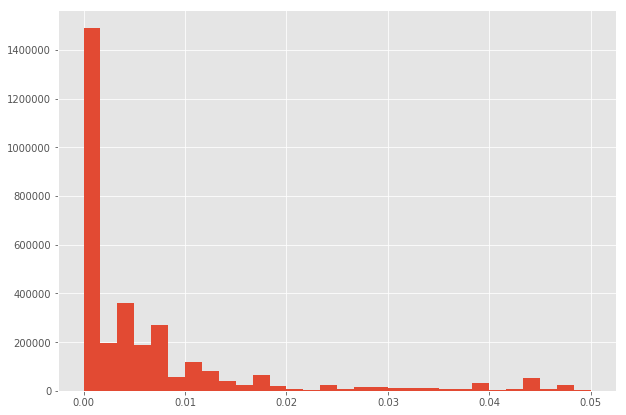

In [25]:
# Expected output

<div class="alert alert-block alert-success">
Very small responses can be all kinds of stuff, but larger ones are probably some relatively big files. Let's have a look at histogram of response sizes between 0.2 and 0.25 MB. Set number of bins to 100.
</div>



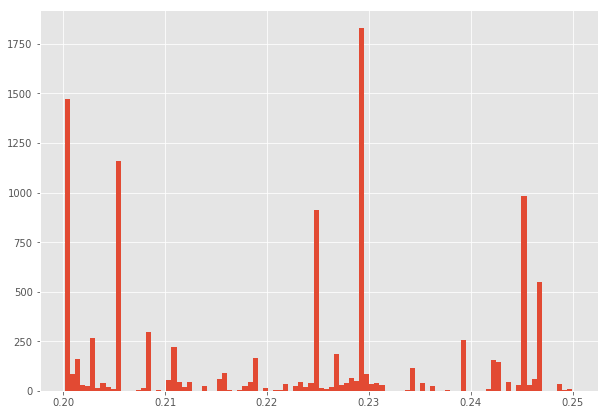

In [212]:
# Fill code here
df_02mb = df[(df["size"] > 0.2) & (df["size"] < 0.25)]
plt.figure(figsize=(10,7))
df_02mb["size"].hist(bins=100)

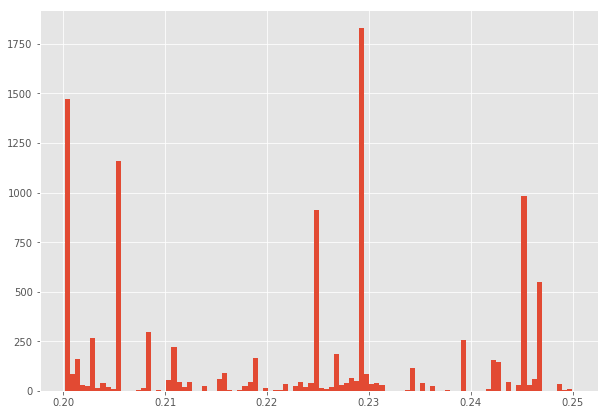

In [34]:
# Expected output

<div class="alert alert-block alert-success">
We now can locate the size of the file more precisely, and find out their names. Show the entries that have response size between 0.222 and 0.223 MB.
</div>



In [216]:
# Fill code here
df_0222mb = df[(df["size"] > 0.222) & (df["size"] < 0.223)]
df_0222mb

,ip,request,size,status
time,,,,
1995-08-05 01:39:04,www-b5.proxy.aol.com,GET /news/sci.space.news/archive/sci-space-new...,0.222006,200
1995-08-09 09:30:10,163.205.11.36,GET /news/sci.space.news/archive/sci-space-new...,0.222006,200


In [36]:
# Expected output

,ip,request,size,status
time,,,,
1995-07-03 22:02:04,gemini.tntech.edu,GET /news/sci.space.news/archive/sci-space-new...,0.221816,200
1995-07-06 15:08:49,jbiagioni.npt.nuwc.navy.mil,GET /shuttle/missions/sts-35/sts-35-patch.jpg ...,0.221627,200
1995-07-07 13:15:42,198.14.55.105,GET /shuttle/missions/sts-35/sts-35-patch.jpg ...,0.221627,200
1995-07-07 17:14:58,ganymedeh4.netdepot.com,GET /news/sci.space.news/archive/sci-space-new...,0.221816,200
1995-07-09 00:26:50,clrc.ca.gov,GET /shuttle/missions/sts-35/sts-35-patch.jpg ...,0.221627,200
1995-07-09 21:48:39,slip37-221.il.us.ibm.net,GET /shuttle/missions/sts-35/sts-35-patch.jpg ...,0.221627,200
1995-07-10 15:15:03,cfdiris.eng.miami.edu,GET /news/sci.space.news/archive/sci-space-new...,0.221227,200
1995-07-10 19:34:49,hmfpc1.berkeley.edu,GET /news/sci.space.news/archive/sci-space-new...,0.221227,200
1995-07-11 19:02:15,dal09.onramp.net,GET /news/sci.space.news/archive/sci-space-new...,0.221227,200


### HTTP status codes

I would like to know how different server responses are distributed through time. Create a new Data Frame that counts the number of requests per status in every 2 hour time spans.

```
HTTP Status Code
----------------
200 - OK
302 - Found
304 - Not Modified
400 - Bad Request
403 - Forbidden 
404 - Not Found
500 - Internal Server Error
501 - Not Implemented
```

<div class="alert alert-block alert-success">
    Create a new Data Frame called <code>df_status</code>that counts the number of requests per status in every 2 hour time spans.
</div>



In [22]:
# Fill code here
df_status = df.copy()

status_code = {200: "OK",
               302: "Found",
               304: "Not Modified",
               400: "Bad Request",
               403: "Forbidden",
               404: "Not Found",
               500: "Internal Server Error",
               501: "Not Implemented"}

for code in df_status["status"].unique():
    str_code = status_code[code]
    df_status[str_code] = (df_status["status"] == code).astype(int)
    
df_status = df_status.drop(columns=["ip", "request", "size", "status"])
df_2t = df_status.resample('120min').sum()
df_2t.head()

,OK,Not Modified,Found,Not Found,Forbidden,Internal Server Error,Not Implemented,Bad Request
time,,,,,,,,
1995-07-01 00:00:00,5915,328,292,34,0,0,0,0
1995-07-01 02:00:00,3603,236,135,28,0,0,0,0
1995-07-01 04:00:00,2517,198,91,19,0,0,0,0
1995-07-01 06:00:00,2684,261,134,6,0,0,0,0
1995-07-01 08:00:00,3565,296,153,9,0,0,0,0


In [27]:
# Expected output

,Bad Request,Forbidden,Found,Not Modified,OK,Not Found,Internal Server Error,Not Implemented
time,,,,,,,,
1995-07-01 00:00:00,0.0,0.0,292,328,5915,34,0.0,0.0
1995-07-01 02:00:00,0.0,0.0,135,236,3603,28,0.0,0.0
1995-07-01 04:00:00,0.0,0.0,91,198,2517,19,0.0,0.0
1995-07-01 06:00:00,0.0,0.0,134,261,2684,6,0.0,0.0
1995-07-01 08:00:00,0.0,0.0,153,296,3565,9,0.0,0.0


<div class="alert alert-block alert-success">
Plot all values at once using lines 
</div>

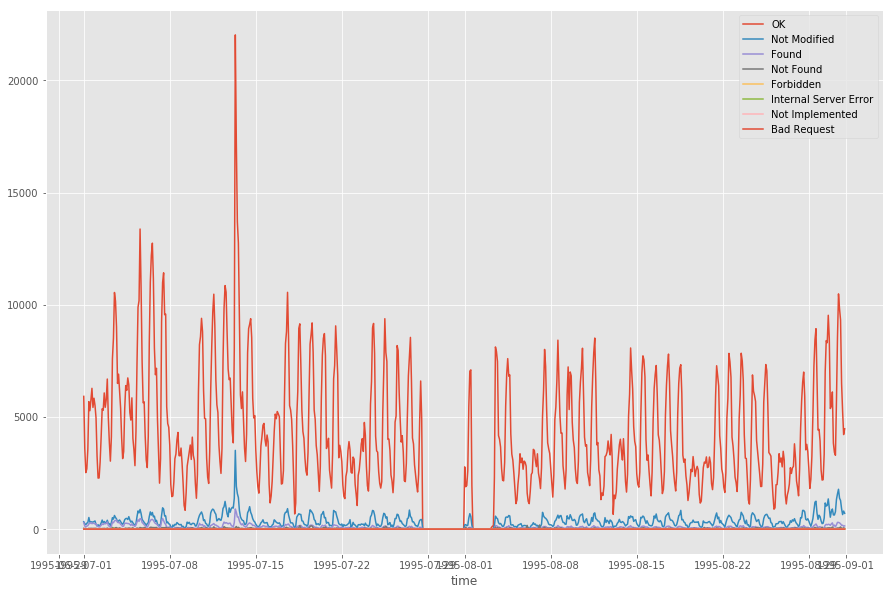

In [107]:
# Fill code here
plt.figure(figsize=(15,10))

for name in list(df_status):
    df_2t[name] = df_2t[name].apply(float) 
    plt.plot(df_2t[name], label=name)

# Add legend
plt.legend(loc='upper right')

# Add title and x, y labels
plt.xlabel("time")
plt.show()

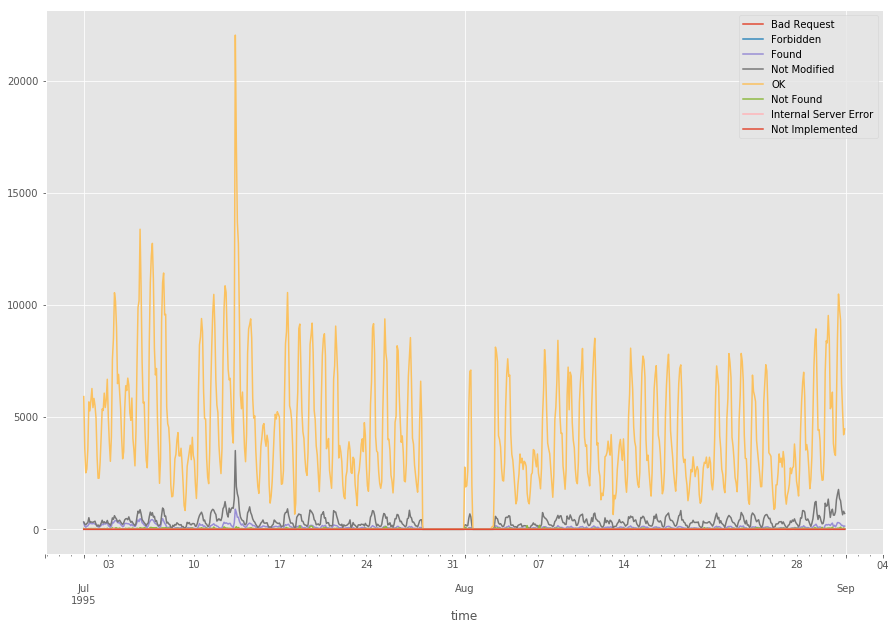

In [28]:
# Expected output

<div class="alert alert-block alert-success">
Show only 'Found' and 'Not Modifies' status codes as a stacked plot. You should show daily data. Use .plot(kind='barh',stacked=True,figsize=(10,7))</div>


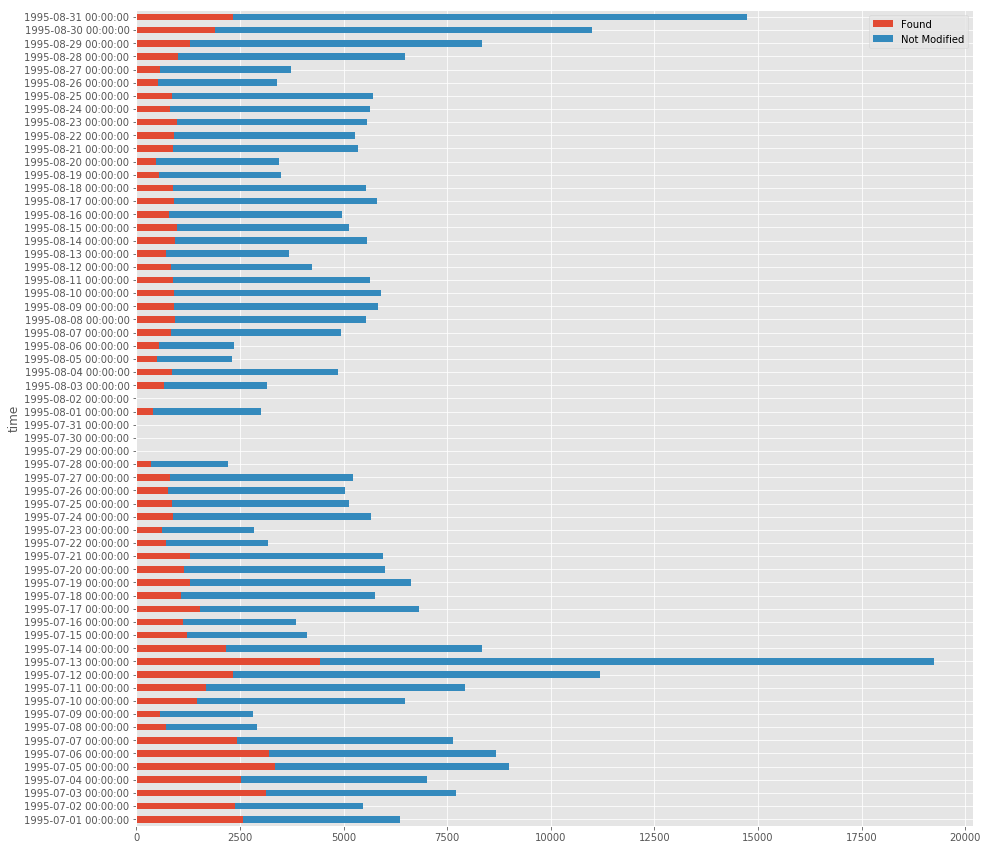

In [40]:
# Fill code here
df_dday = df_status.resample('1440min').sum()

df_dday = df_dday[["Found", "Not Modified"]] 
df_dday.plot(kind='barh',stacked=True,figsize=(15,15))

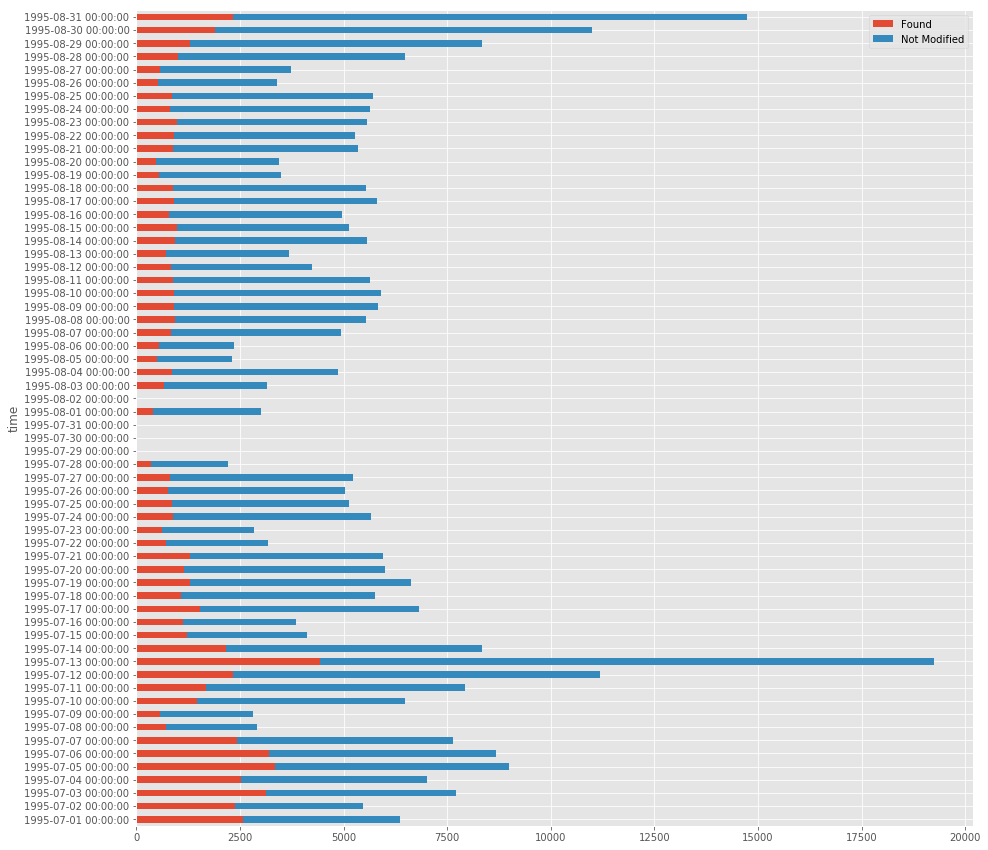

In [31]:
# Expected output

But there is a better way to receive statistics about different groups of values. Here we group our data by *Status* by using `.groupby()`

In [48]:
grouped_status = df.groupby('status')

Data are now rearranged in to several groups, each corresponding to a certain value of *Status* (here, only the first two values of every group are shown):

In [33]:
grouped_status.head(2)

,ip,request,size,status
time,,,,
1995-07-01 00:00:01,199.72.81.55,GET /history/apollo/ HTTP/1.0,0.005956,200
1995-07-01 00:00:06,unicomp6.unicomp.net,GET /shuttle/countdown/ HTTP/1.0,0.003800,200
1995-07-01 00:00:11,burger.letters.com,GET /shuttle/countdown/liftoff.html HTTP/1.0,0.000000,304
1995-07-01 00:00:12,burger.letters.com,GET /images/NASA-logosmall.gif HTTP/1.0,0.000000,304
1995-07-01 00:01:06,205.189.154.54,"GET /cgi-bin/imagemap/countdown?99,176 HTTP/1.0",0.000105,302
1995-07-01 00:01:12,dd15-062.compuserve.com,GET /news/sci.space.shuttle/archive/sci-space-...,NaN,404
1995-07-01 00:01:53,remote27.compusmart.ab.ca,"GET /cgi-bin/imagemap/countdown?102,174 HTTP/1.0",0.000105,302
1995-07-01 00:10:19,netport-27.iu.net,GET /pub/winvn/readme.txt HTTP/1.0,NaN,404
1995-07-02 00:55:38,pc0135.metrolink.net,GET /shuttle/missions/sts-71/images/images/eks...,NaN,403


<div class="alert alert-block alert-success">
Plot the size of each group. Use .size()
</div>

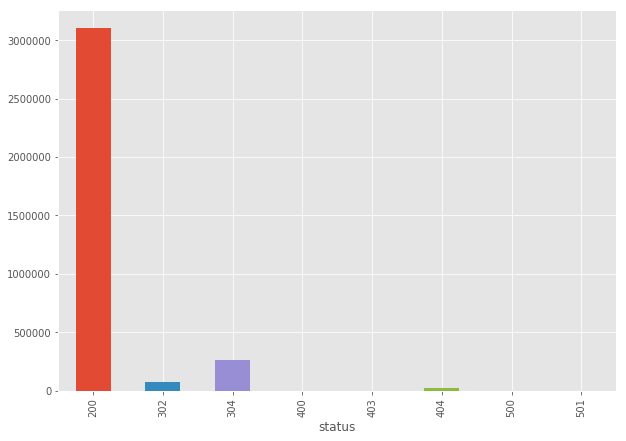

In [46]:
# Fill code here
df_grouped = grouped_status.size()
plt.figure(figsize=(10,7))
df_grouped.plot(kind='bar')

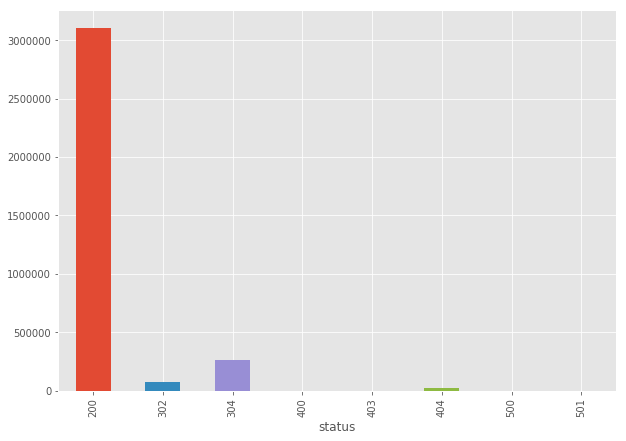

In [34]:
# Expected output

###  IP addresses

<div class="alert alert-block alert-success">
Now I want to group by IPs and calculate how many requests we get from each of them: 
</div>

In [54]:
# Fill code here
grouped_ip = df.groupby('ip')
counted_ip = grouped_ip.size()
counted_ip.head()

ip
***.novo.dk                        32
001.msy4.communique.net             8
007.thegap.com                     49
01-dynamic-c.rotterdam.luna.net     1
01-dynamic-c.wokingham.luna.net    59
dtype: int64

In [35]:
# Expected output

ip
***.novo.dk                        32
001.msy4.communique.net             8
007.thegap.com                     49
01-dynamic-c.rotterdam.luna.net     1
01-dynamic-c.wokingham.luna.net    59
dtype: int64

<div class="alert alert-block alert-success">
Show top 10 IPs and number of requests as a horizontal bar chart.
</div>

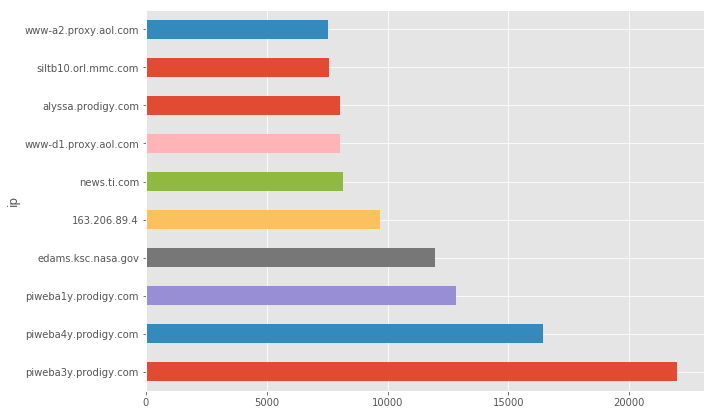

In [102]:
# Fill code here
sorted_ip = counted_ip.sort_values(ascending=False)
top_10_ip = sorted_ip.head(10)

plt.figure(figsize=(10,7))
top_10_ip.plot(kind='barh')

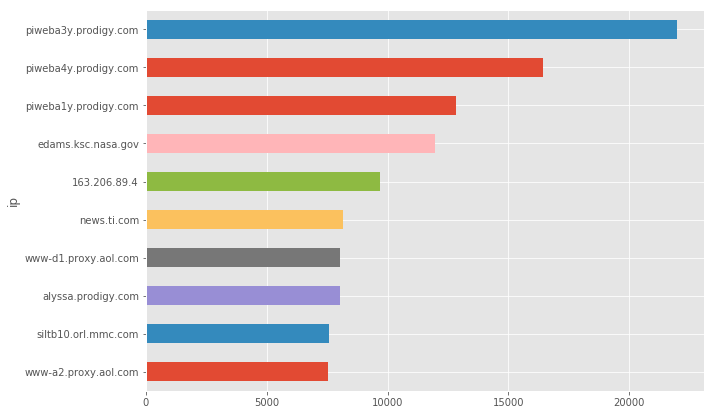

In [38]:
# Expected output

<div class="alert alert-block alert-success">
I just want to have a nice dataframe with the top 10 IPs. Create a dataframe called <code>df_top10</code> whose only column is 'Number of requests'. 
</div>


In [103]:
# Fill code here
df_top10 = pd.DataFrame(top_10_ip, columns=['Number of requests'])
df_top10

,Number of requests
ip,
piweba3y.prodigy.com,21988
piweba4y.prodigy.com,16437
piweba1y.prodigy.com,12825
edams.ksc.nasa.gov,11964
163.206.89.4,9697
news.ti.com,8161
www-d1.proxy.aol.com,8047
alyssa.prodigy.com,8037
siltb10.orl.mmc.com,7573


In [40]:
# Expected output

,Number of requests
ip,
www-a2.proxy.aol.com,7516
siltb10.orl.mmc.com,7573
alyssa.prodigy.com,8037
www-d1.proxy.aol.com,8047
news.ti.com,8161
163.206.89.4,9697
edams.ksc.nasa.gov,11964
piweba1y.prodigy.com,12825
piweba4y.prodigy.com,16437


<div class="alert alert-block alert-success">
We also can group by both *IP* and *Status*. Try and produce the bar chart as shown below.
</div>

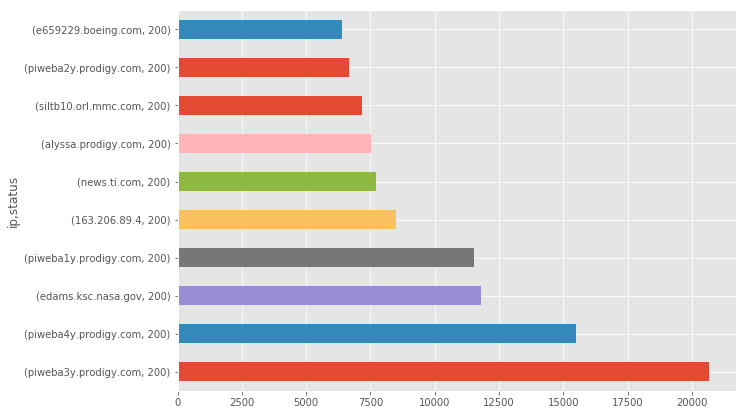

In [114]:
# Fill code here
grouped_ip_status = df.groupby(['ip','status']).size().sort_values(ascending=False)
top10_ip_status = grouped_ip_status.head(10)
plt.figure(figsize=(10,7))
top10_ip_status.plot(kind='barh')

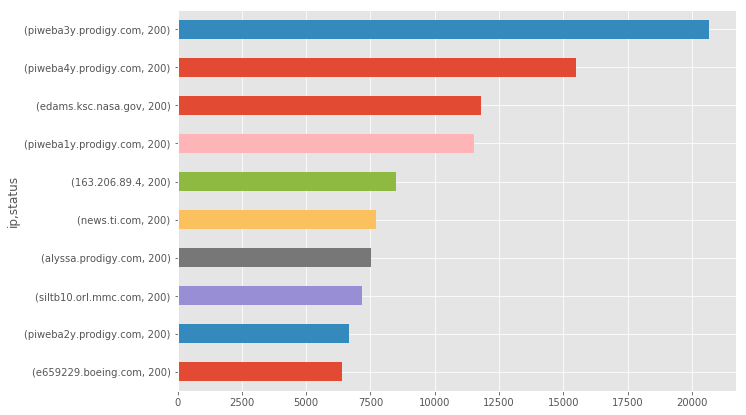

In [41]:
# Expected output

### Geographical information

In this part, you will further analyze the log file by cross-checking the ip/hostname with GeoIP data. This will let you know the geographical origin of the request.

You will be 'pygeoip' package, which can be easily installed by `pip install pygeoip`

In [115]:
import pygeoip
gi = pygeoip.GeoIP('data/GeoIP.dat', pygeoip.MEMORY_CACHE)

One of the challenges for this part is that some entries are not the IP addresses but hostnames. Here is excerpt from pygeoip API. You can use these function to get the country code.

```
country_code_by_addr(addr) -- Returns 2-letter country code (e.g. US) from IP address.
    Parameters:	addr – IP address (e.g. 203.0.113.30)

country_code_by_name(hostname) -- Returns 2-letter country code (e.g. US) from hostname.
    Parameters:	hostname – Hostname (e.g. example.com)
```



<div class="alert alert-block alert-warning">
    <b>Caution:</b> Looking up IP addresses can be extremely slow. It's okay to do this on a subset of data, say 500 rows.
</div>

<div class="alert alert-block alert-success">
    Complete the function below
</div>


In [195]:
# Fill code here
def geo_ip(ip):
    try: return gi.country_code_by_addr(ip)
    except:
        try: return gi.country_code_by_name(ip)
        except: return 'UNKNOWN'
    
print(geo_ip('163.206.89.4'))
print(geo_ip('piweba3y.prodigy.com'))
print(geo_ip('edams.ksc.nasa.gov'))

US
UNKNOWN
US


<div class="alert alert-block alert-success">
    Create Data Frame similar to what shown below
</div>


In [169]:
# Fill code here

df_ip = pd.DataFrame(combined)

In [204]:
sorted_df_ip = df_ip.groupby('ip').size().sort_values(ascending=False)
df_sorted_ip = pd.DataFrame(sorted_df_ip.head(500), columns=['count'])
df_sorted_ip['cc'] = df_sorted_ip.index.map(geo_ip)
df_sorted_ip.head()

,count,cc
ip,,
piweba3y.prodigy.com,21988,UNKNOWN
piweba4y.prodigy.com,16437,UNKNOWN
piweba1y.prodigy.com,12825,UNKNOWN
edams.ksc.nasa.gov,11964,US
163.206.89.4,9697,US


In [21]:
# Expected output

,ip,count,cc
0,piweba3y.prodigy.com,21988,UNKNOWN
1,piweba4y.prodigy.com,16437,UNKNOWN
2,piweba1y.prodigy.com,12825,UNKNOWN
3,edams.ksc.nasa.gov,11964,US
4,163.206.89.4,9697,US


<div class="alert alert-block alert-success">
    Group by country code:
</div>



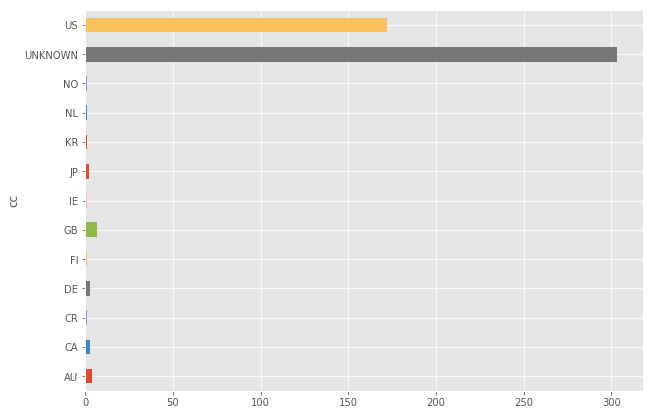

In [210]:
# Fill code here

grouped_cc = df_sorted_ip.groupby('cc').size()
plt.figure(figsize=(10,7))
grouped_cc.plot(kind='barh')

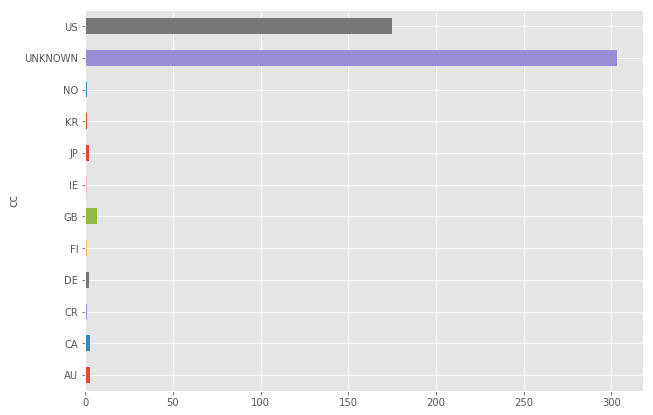

In [85]:
# Expected output